# Personal Project
> Nama: **Agung Besti**

> Name Project: **Image Classification Model Deployment (Fruits)**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [3]:
#changing the working directory
%cd /content/gdrive/My Drive/kaggle/fruits

/content/gdrive/My Drive/kaggle/fruits


In [4]:
!kaggle datasets download -d moltean/fruits

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
os.listdir('/content/gdrive/MyDrive/kaggle/fruits')

['fruits.zip']

In [6]:
#Library
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [7]:
import zipfile
local_zip = '/content/gdrive/MyDrive/kaggle/fruits/fruits.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [8]:
os.listdir('/content/gdrive/MyDrive/kaggle/fruits/')

['fruits.zip', 'fruits-360']

In [9]:
print("List folder train: "+str(os.listdir('/content/gdrive/MyDrive/kaggle/fruits/fruits-360/Training/')))
dir_dataset = "/content/gdrive/MyDrive/kaggle/fruits/fruits-360/Training/"

List folder train: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado ripe', 'Avocado', 'Banana Lady Finger', 'Banana Red', 'Banana', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn Husk', 'Corn', 'Cucumber Ripe 2', 'Cucumber Ripe', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grape White', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon Meyer', 'Lemon', 'Limes', 'Lychee', 'Mandarine', 'Mango Red', 'Mango', 'Mangostan'

In [10]:
# Mengecek jumlah data fruits
import glob 
total_image = len(list(glob.iglob("/content/gdrive/MyDrive/kaggle/fruits/fruits-360/Training/*/*.*", recursive=True)))
print("Total Data Image JPEG     : ",total_image)
className = glob.glob('/content/gdrive/MyDrive/kaggle/fruits/fruits-360/Training/*' )
numberOfClass = len(className)
print("Total Kelas Data Image     : ",numberOfClass)

Total Data Image JPEG     :  67692
Total Kelas Data Image     :  131


In [11]:
#Merubah image menjadi array
img = load_img("/content/gdrive/MyDrive/kaggle/fruits/fruits-360/Training/Apple Braeburn/0_100.jpg")
x = img_to_array(img)
print(x.shape)

(100, 100, 3)


**Implementasi Image Data Generator Tensorflow untuk pengolahan gambar**

In [12]:
#Ukuran validation 20% dari dataset
val_size = 0.2

Train_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

Validation_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

Mengsplit dataset menjadi **train set** dan **validation set** 
dengan proporsi **80% train set** dan **20% val set**

In [13]:
batch_size = 32
# Train dan Validation generator  dengan mode categorical
Train_generator = Train_datagen.flow_from_directory(
    dir_dataset,
    target_size = x.shape[:2],
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = batch_size,
    subset = "training"
)

Validation_generator = Validation_datagen.flow_from_directory(
    dir_dataset,
    target_size = x.shape[:2],
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = batch_size,
    subset = "validation"
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


In [14]:
#Membuat fungsi recall untuk mengukur tingkat keberhasilan sistem dalam menemukan kembali sebuah informasi.
def rec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
#Membuat fungsi Precision untuk mengukur tingkat ketepatan antara informasi yang diminta. 
def prec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [15]:
# Pembuatan model dengan tipe Sequential

model = Sequential(
    [
     Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', input_shape = x.shape),
     MaxPooling2D(pool_size = (2,2)),
     
     Conv2D(filters = 32, kernel_size = (3,3), activation ='relu'),
     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

     Conv2D(filters = 32, kernel_size = (3,3), activation ='relu'),
     MaxPooling2D(pool_size=(2,2), strides=(2,2)),

     Flatten(),
     Dense(1024, activation = "relu"),
     Dropout(0.5),
     Dense(numberOfClass, activation = "softmax")
    ]
)


In [16]:
# Optimasi Adam dengan learning rate 0.001
Adam(learning_rate=0.00146, beta_1=0.9, beta_2=0.999, name='Adam')
model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', prec, rec])

**Penggunaan Learning Rate Schedule dan Callbacks**

In [17]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAkurasi train dan validasi didapat telah mencapai nilai > 92%!")
      self.model.stop_training = True
callbacks = myCallback()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='/content/gdrive/MyDrive/kaggle/fruits/fruits-360/logs', 
    histogram_freq=0, 
    write_graph=True, 
    write_images=False,
    update_freq='epoch', 
    embeddings_freq=0,
    embeddings_metadata=None
)
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience = 3
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

In [18]:
#Model Adam
print("\nStart Training Model Adam\n")
start_time = time.time()
with tf.device("/device:GPU:0"):
  history = model.fit(
      Train_generator,
      steps_per_epoch = 1600 // batch_size,
      epochs = 100,
      validation_data = Validation_generator,
      validation_steps = 800 // batch_size,
      callbacks =[lr_schedule, tb_callback, es, callbacks]
  )
print("\nStop Training")
timeadamax = ((time.time() - start_time)/60)
print("Duration Learning : ",((time.time() - start_time)/60))


Start Training Model Adam


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/100
 1/50 [..............................] - ETA: 0s - loss: 4.9221 - accuracy: 0.0000e+00 - prec: 0.0000e+00 - rec: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - 32s 649ms/step - loss: 4.7027 - accuracy: 0.0256 - prec: 0.0200 - rec: 6.2500e-04 - val_loss: 4.3900 - val_accuracy: 0.0300 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/100
50/50 [==============================] - 32s 637ms/step - loss: 3.9877 - accuracy: 0.0769 - prec: 0.0500 - rec: 0.0019 - val_loss: 3.5995 - val_accuracy: 0.1175 - val_

Plot Accuracy, Loss, Precision dan Recall

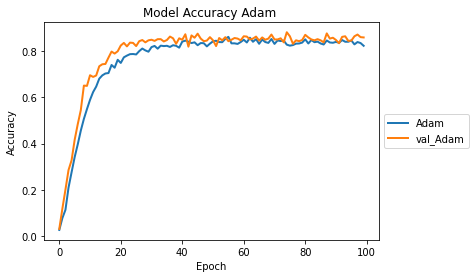

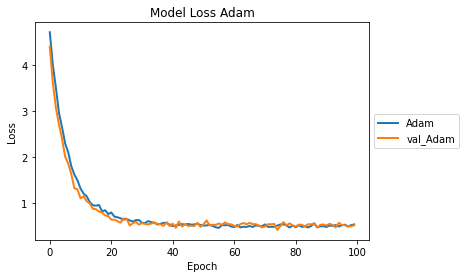

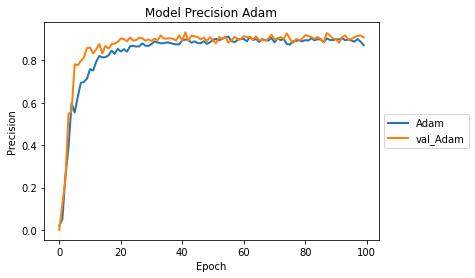

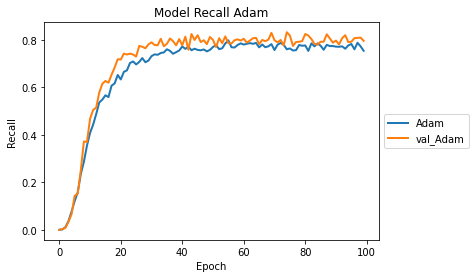

In [19]:
# visualisasi hasil data training
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
#Nadam
acc_adam = history.history['accuracy']
val_acc_adam = history.history['val_accuracy']
loss_adam = history.history['loss']
val_loss_adam = history.history['val_loss']
prec_adam = history.history['prec']
val_prec_adam = history.history['val_prec']
rec_adam = history.history['rec']
val_rec_adam = history.history['val_rec']

# Visualisasi Accuracy Model
plt.plot(acc_adam, label='Adam', color=new_colors[0],linewidth=2)
plt.plot(val_acc_adam, label='val_Adam', color=new_colors[1],linewidth=2)
plt.title('Model Accuracy Adam ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# Visualisasi Loss Model
plt.plot(loss_adam, label='Adam', color=new_colors[0],linewidth=2)
plt.plot(val_loss_adam, label='val_Adam', color=new_colors[1],linewidth=2)
plt.title('Model Loss Adam')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# Visualisasi Precision Model
plt.plot(prec_adam, label='Adam', color=new_colors[0],linewidth=2)
plt.plot(val_prec_adam, label='val_Adam', color=new_colors[1],linewidth=2)
plt.title('Model Precision Adam')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# Visualisasi Recall Model
plt.plot(rec_adam, label='Adam', color=new_colors[0],linewidth=2)
plt.plot(val_rec_adam, label='val_Adam', color=new_colors[1],linewidth=2)
plt.title('Model Recall Adam')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Export model Tflite

In [20]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpw2b53gmf/assets
